# Visualizing the data structure



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm, TwoSlopeNorm
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import markers
from scipy.interpolate import CubicSpline

import jax
# jax.config.update("jax_enable_x64", True)

from pymob import Config, SimulationBase
from pymob.sim.plot import SimulationPlot

In [2]:
# load case study
config = Config("../scenarios/model_inspection/settings.cfg")
config.case_study.root = "../../.."
config.import_casestudy_modules()

from case_studies.hierarchical_molecular_tktd.sim import NomixHierarchicalSimulation, conditional_survival_error_model, conditional_survival_error_model_old
sim = NomixHierarchicalSimulation(config)

Working directory: '/home/flo-schu/projects/pymob'.
Inserted '/home/flo-schu/projects/pymob/case_studies' in PATH at index=0
Inserted '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd' in PATH at index=0
Inserted './case_studies' in PATH at index=0
Inserted './case_studies/tktd_rna_pulse' in PATH at index=0
Inserted './case_studies' in PATH at index=0
Inserted './case_studies/tktd_rna_pulse' in PATH at index=0


/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


In [3]:
sim.setup()

Inserted '/home/flo-schu/projects/pymob/case_studies' into PATH at index=0
Inserted '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd' into PATH at index=0
MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd/results/model_inspection'.
Scenario directory exists at '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd/scenarios/model_inspection'.


In [4]:
sim.dispatch_constructor()
e = sim.dispatch({})
e()
e.results


<xarray.Dataset>
Dimensions:          (id: 314, time: 23)
Coordinates:
  * id               (id) object '101_0' '101_1' '106_0' ... '77_7' '77_8'
  * time             (time) float64 24.0 25.5 27.0 30.0 ... 114.0 117.0 120.0
    hpf              (id) float64 24.0 24.0 24.0 24.0 ... 24.0 24.0 24.0 24.0
    nzfe             (id) float64 nan nan nan nan nan ... 18.0 18.0 18.0 18.0
    treatment_id     (id) int64 101 101 106 106 112 112 ... 77 77 77 77 77 77
    experiment_id    (id) int64 36 36 36 36 36 36 36 36 ... 31 31 31 31 31 31 31
    substance        (id) <U10 'diuron' 'diuron' ... 'naproxen' 'naproxen'
    substance_index  (id) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2 2
Data variables:
    cext             (id, time) float32 2.34 2.34 2.34 ... 309.2 309.2 309.2
    cint             (id, time) float32 0.0 1.755 3.51 ... 1.438e+04 1.484e+04
    nrf2             (id, time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    P                (id, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    H                (id, time) float32 0.0 1.5e-07 3e-07 ... 9.3e-06 9.6e-06
    survival         (id, time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

In [5]:

sim.config.inference_numpyro.kernel = "svi"
sim.config.inference_numpyro.draws = 2000
sim.config.inference_numpyro.svi_iterations = 1000
sim.config.jaxsolver.throw_exception = False
sim.config.jaxsolver.atol = 1e-6
sim.config.jaxsolver.rtol = 1e-3
sim.config.jaxsolver.pcoeff = 0.2
sim.config.jaxsolver.icoeff = 0.4

sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.use_numpyro_backend(
    error_model=conditional_survival_error_model,
    only_prior=False
)


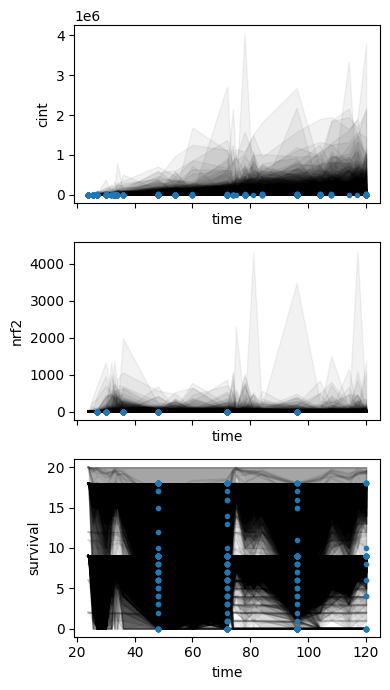

In [6]:
idata = sim.inferer.prior_predictions(n=10)

checks = {}
flag = sim.inferer.check_prior_for_nans(idata=idata)
checks.update({"NaN values in prior draws": flag})

if not all(checks.values()):
    raise ValueError("Not all checks passed.")

simplot = SimulationPlot(
    observations=sim.observations,
    idata=idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["prior_predictive"],
)   
simplot.plot_data_variables()


                  Trace Shapes:         
                   Param Sites:         
                  Sample Sites:         
 k_i_substance_normal_base dist      3 |
                          value      3 |
r_rt_substance_normal_base dist      3 |
                          value      3 |
r_rd_substance_normal_base dist      3 |
                          value      3 |
v_rt_substance_normal_base dist      3 |
                          value      3 |
z_ci_substance_normal_base dist      3 |
                          value      3 |
 k_p_substance_normal_base dist      3 |
                          value      3 |
 k_m_substance_normal_base dist      3 |
                          value      3 |
 h_b_substance_normal_base dist      3 |
                          value      3 |
   z_substance_normal_base dist      3 |
                          value      3 |
  kk_substance_normal_base dist      3 |
                          value      3 |
    sigma_nrf2_normal_base dist      3 |
                

100%|██████████| 1000/1000 [01:02<00:00, 16.01it/s, init loss: 9684.7930, avg. loss [951-1000]: 1451.3214]
/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: 

                                mean  sd    hdi_3%   hdi_97%  mcse_mean  \
ci_max[101_0]               1757.000 NaN  1757.000  1757.000        NaN   
ci_max[101_1]               1757.000 NaN  1757.000  1757.000        NaN   
ci_max[106_0]               1757.000 NaN  1757.000  1757.000        NaN   
ci_max[106_1]               1757.000 NaN  1757.000  1757.000        NaN   
ci_max[112_0]               1757.000 NaN  1757.000  1757.000        NaN   
...                              ...  ..       ...       ...        ...   
z_ci_substance[diclofenac]     0.465 NaN     0.465     0.465        NaN   
z_ci_substance[naproxen]       1.038 NaN     1.038     1.038        NaN   
z_substance[diuron]            1.286 NaN     1.286     1.286        NaN   
z_substance[diclofenac]        1.744 NaN     1.744     1.744        NaN   
z_substance[naproxen]          2.506 NaN     2.506     2.506        NaN   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
ci_max[101_0]                   Na

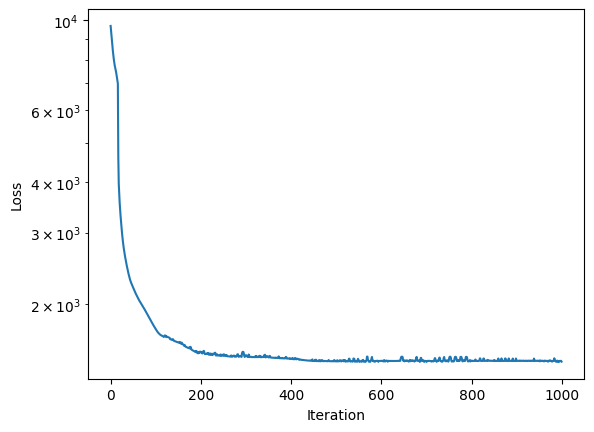

In [7]:
sim.config.inference_numpyro.kernel = "map"
sim.config.inference_numpyro.init_strategy = "init_to_uniform"
sim.config.inference_numpyro.svi_iterations = 1000
sim.config.inference_numpyro.svi_learning_rate = 0.01
sim.config.simulation.seed=4
sim.dispatch_constructor()

if True:
    sim.inferer.run()
    sim.inferer.store_results(output="numpyro_svi_posterior.nc")
    idata = sim.inferer.idata
else:
    idata = sim.inferer.load_results(file="numpyro_svi_posterior")

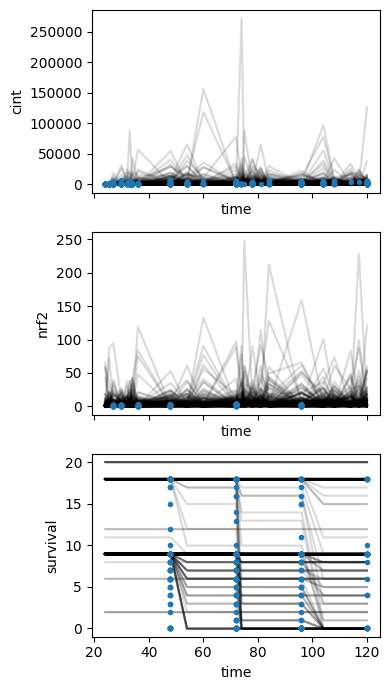

In [8]:
simplot = SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["posterior_predictive"],
)   
simplot.plot_data_variables()

In [9]:
sim.seed=1
sim.config.inference.n_predictions = 1
sim.coordinates["time"] = np.linspace(24,120,200)
sim.dispatch_constructor()
sim._plot.pretty_posterior_plot_multisubstance(sim)
sim.reset_coordinate("time")

PRETTY PLOT: starting...


Posterior predictions: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


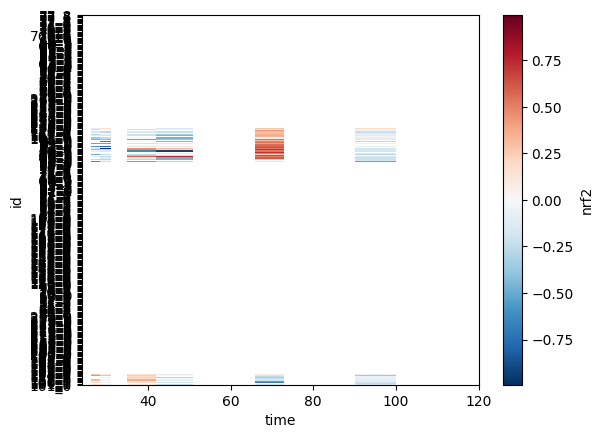

In [10]:
idata.posterior_residuals.nrf2.mean(("chain","draw")).plot()

In [13]:
sim.config.case_study.scenario = "hierarchical_cext"
sim.config.create_directory("scenario", force=True)
sim.config.save(force=True)

Scenario directory created at '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext'.
